In [52]:
import pandas as pd
import numpy as np

# Read the CSV file
data = pd.read_csv('tgp_samp_avg_0002.csv')  # Replace 'your_file.csv' with the path to your CSV file

# Extract the columns into numpy arrays
targets_pred = np.array(data['TGP_avg']).reshape(-1, 1)  # Reshape to nx1
stdevs = np.array(data['TGP_avg_std']).reshape(-1, 1)  # Reshape to nx1

# # Print the results (optional)
# print("Mean Array:")
# print(tgp_mean_array)
# print("Standard Deviation Array:")
# print(tgp_std_array)


# # Read the CSV file
# data = pd.read_csv('real_samp_avg_0002.csv')  # Replace 'your_file.csv' with the path to your CSV file

# # Extract the columns into numpy arrays
# targets_val = np.array(data['GP_avg']).reshape(-1, 1)  # Reshape to nx1
# real_std_array = np.array(data['GP_avg_std']).reshape(-1, 1)  # Reshape to nx1

# # # Print the results (optional)
# # print("Mean Array:")
# # print(real_mean_array)
# # print("Standard Deviation Array:")
# # print(real_std_array)

df = pd.read_csv('real_results_test_0002.csv')

# 提取第二列并转换为 numpy 数组
targets_val = df.iloc[:, 1].values.reshape(-1, 1)

# print(targets_val.shape, targets_val)


residuals = targets_pred - targets_val
print("residual Array:")
print(residuals.shape, residuals)


residual Array:
(100, 1) [[ 0.07365365]
 [ 0.02116013]
 [ 0.0330297 ]
 [ 0.0112342 ]
 [ 0.00252291]
 [ 0.00515128]
 [ 0.05338439]
 [-0.00711023]
 [-0.00237116]
 [ 0.01926622]
 [ 0.04549112]
 [-0.00670592]
 [ 0.02266879]
 [ 0.0222229 ]
 [ 0.03077676]
 [ 0.00327003]
 [ 0.05121146]
 [-0.00418611]
 [-0.00511202]
 [ 0.04385821]
 [ 0.03312937]
 [ 0.04335202]
 [ 0.00114475]
 [-0.01594874]
 [ 0.09412681]
 [ 0.00109702]
 [ 0.04387793]
 [ 0.01415549]
 [ 0.01193653]
 [ 0.00650159]
 [ 0.02901588]
 [-0.0024241 ]
 [ 0.03348796]
 [ 0.00947036]
 [-0.03269834]
 [-0.00971727]
 [ 0.02130974]
 [-0.00213487]
 [ 0.00456692]
 [ 0.05079559]
 [ 0.02872822]
 [-0.02937017]
 [ 0.02585685]
 [-0.01469845]
 [ 0.0177606 ]
 [ 0.03589925]
 [ 0.02236893]
 [ 0.04123428]
 [ 0.02505889]
 [-0.00296244]
 [ 0.01412079]
 [ 0.03942714]
 [ 0.03051   ]
 [ 0.068414  ]
 [ 0.02396711]
 [ 0.02606414]
 [ 0.01968316]
 [-0.03324263]
 [ 0.00312169]
 [ 0.01760441]
 [ 0.02985939]
 [ 0.02328952]
 [ 0.01452761]
 [ 0.04104988]
 [ 0.08731247]


In [53]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 7.5/3  # 1/3 of a page
fontsize = 20
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

R2 = 0.91
PPMCC = 0.97


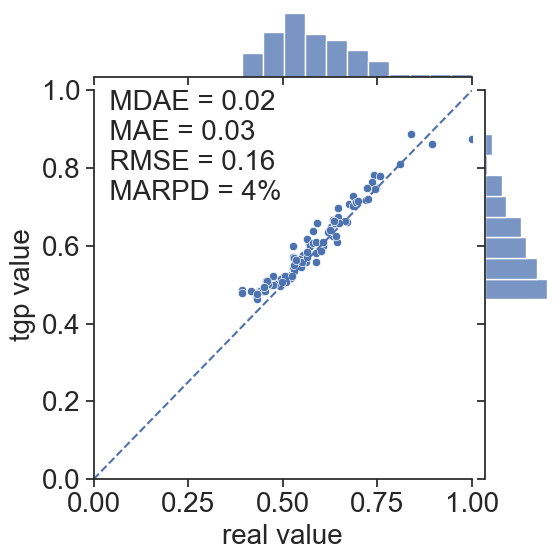

In [54]:
%matplotlib inline
import pickle
import numpy as np
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)
import seaborn as sns


# Load the results
# with open('predictions.pkl', 'rb') as file_handle:
#     residuals, stdevs = pickle.load(file_handle)
# targets_pred = targets_val.detach().cpu().numpy() + residuals


data = pd.DataFrame({'val': targets_val.reshape(-1), 'pred': targets_pred.reshape(-1)})

# Plot
lims = [0, 1]

grid = sns.jointplot(data, x="val", y="pred")


ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('real value')
_ = ax.set_ylabel('tgp value')

# Calculate the error metrics
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_absolute_error(targets_val, targets_pred))
mdae = median_absolute_error(targets_val, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred) + np.abs(targets_val.reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_val, targets_pred)
corr = np.corrcoef(targets_val.reshape(-1), targets_pred.reshape(-1))[0, 1]

# Report
text = ('  MDAE = %.2f \n' % mdae + 
        '  MAE = %.2f \n' % mae + 
        '  RMSE = %.2f \n' % rmse + 
        '  MARPD = %i%%\n' % marpd)
print('R2 = %.2f' % r2)
print('PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize)

In [55]:
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook
# from tqdm.notebook import tqdm


# Define a normalized bell curve we'll be using to calculate calibration
norm = stats.norm(loc=0, scale=1)


def calculate_density(percentile):
    '''
    Calculate the fraction of the residuals that fall within the lower
    `percentile` of their respective Gaussian distributions, which are
    defined by their respective uncertainty estimates.
    '''
    # Find the normalized bounds of this percentile
    upper_bound = norm.ppf(percentile)

    # Normalize the residuals so they all should fall on the normal bell curve
    normalized_residuals = residuals.reshape(-1) / stdevs.reshape(-1)

    # Count how many residuals fall inside here
    num_within_quantile = 0
    for resid in normalized_residuals:
        if resid <= upper_bound:
            num_within_quantile += 1

    # Return the fraction of residuals that fall within the bounds
    density = num_within_quantile / len(residuals)
    return density


predicted_pi = np.linspace(0, 1, 100)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

calibration_error = ((predicted_pi - observed_pi)**2).sum()
print('Calibration error = %.2f' % calibration_error)

/var/folders/wl/t5dkzw3j6lj6f7fdgyzbdxww0000gn/T/ipykernel_4087/1295446737.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]


Calibration:   0%|          | 0/100 [00:00<?, ?it/s]

Calibration error = 4.01


In [56]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

/var/folders/wl/t5dkzw3j6lj6f7fdgyzbdxww0000gn/T/ipykernel_4087/4028105561.py:51: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)


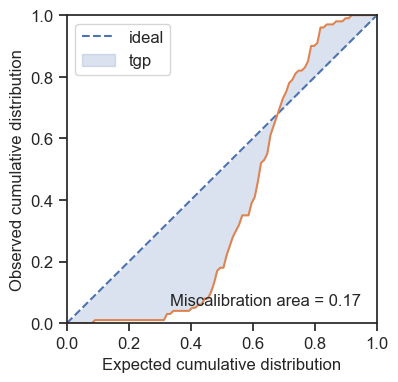

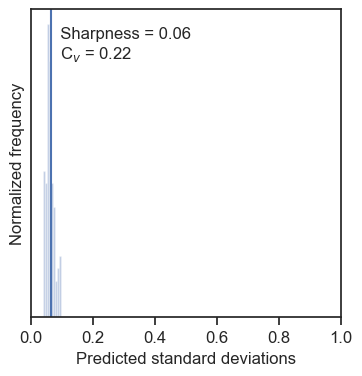

In [57]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize, unary_union


# Plot settings
figsize = (width, width)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
# ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
ax_ideal = sns.lineplot([0, 1])
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(x=predicted_pi, y=observed_pi, label='tgp')
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected cumulative distribution')
_ = ax_ideal.set_ylabel('Observed cumulative distribution')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])
_ = plt.legend(labels=['ideal', 'tgp'], loc='upper left')

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
x, y = polygon.exterior.xy # original data
ls = LineString(np.c_[x, y]) # closed, non-simple
lr = LineString(ls.coords[:] + ls.coords[0:1])
mls = unary_union(lr)
polygon_area_list =[poly.area for poly in polygonize(mls)]
miscalibration_area = np.asarray(polygon_area_list).sum()

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.2f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=fontsize)

# Plot sharpness curve
xlim = [0., 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviations')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness/dispersion
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
dispersion = np.sqrt(((stdevs - stdevs.mean())**2).mean()) / stdevs.mean()
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f \n  C$_v$ = %.2f' % (sharpness, dispersion)
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  \nC$_v$ = %.2f  ' % (sharpness, dispersion)
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align,
                  fontsize=fontsize)

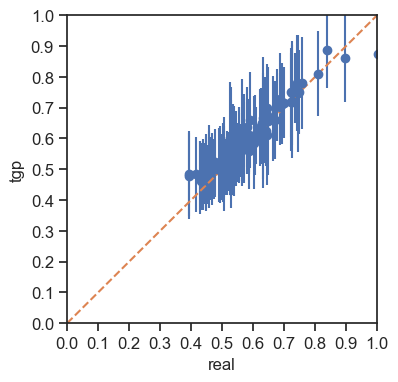

In [58]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt


# Pull a random sample of the data, because plotting thousands of these at once would look absurd
all_predictions = list(zip(targets_pred.reshape(-1), targets_val.reshape(-1), stdevs.reshape(-1)))
samples = random.sample(all_predictions, k=100)

# Parse the samples
_preds, _targets, _stdevs = zip(*samples)
_preds = np.array(_preds)
_targets = np.array(_targets)
_stdevs = np.array(_stdevs)

# Plot
fig = plt.figure(figsize=(4, 4))
_ = plt.errorbar(_targets, _preds, yerr=2*_stdevs, fmt='o')
ax = plt.gca()

# Make a parity line
lims = [0, 1]
_ = ax.plot(lims, lims, '--')

# Format
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.set_xticks(np.arange(0, 1.1, 0.1))
_ = ax.set_yticks(np.arange(0, 1.1, 0.1))
_ = ax.set_xlabel('real')
_ = ax.set_ylabel('tgp')

# Save
_ = plt.savefig('error_bar_parity.pdf', dpi=300, bbox_inches='tight', transparent=True)